(geopandas2)=
# Geometric operations

In [91]:
!echo Last updated: `date +'%Y-%m-%d %H:%M:%S'`

Last updated: 2022-07-14 11:41:17


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (6, 6)

*****

## Introduction

In the previous chapter we introduced the `geopandas` package, focusing on non-spatial operations such as subsetting by attributes (see {ref}`subsetting-by-attributes`), as well as geometry-related transformations (see {ref}`point-layer-from-table` and {ref}`geopandas-points-to-line`).

In this chapter, we go further into operations that involve the geometric component of one or more `GeoDataFrame` vector layer, using the `geopandas` package. This group of operations includes the following standard spatial analysis functions:

* {ref}`geopandas-reprojection`—Transforming a given layer from one CRS to another
* {ref}`geopandas-numeric-calculations`—Calculating numeric geometry properties, such as length, area, and distance
* {ref}`geopandas-new-geometries`—Creating new geometries, such as calculating buffers, or area of intersection
* {ref}`geopandas-geometric-relations`—Evaluating the relation between layers, such as whether two geometries intersect
* {ref}`geopandas-spatial-join`—Joining attributes from one layer to another, based on spatial relations

By the end of this chapter, you will have an overview of all common worflows in spatial analysis of vector layers.

(geopandas2-sample-data)=
## Sample data

### Overview

First, let us prepare the environment to demostrate geometric operations using `geopandas`. First, we load the `geopandas` package: 

In [93]:
import geopandas as gpd

Next, let us load three layers, subset the relevant columns, and examine them visually. The first two (`towns` and `rail`) are familiar from the previous chapter (see {ref}`reading-vector-layers`), while the third one (`stations`) is new:

* `towns`—A polygonal layer of towns (see {ref}`towns-layer`)
* `rail`—A line layer of railway lines (see {ref}`rail-layer`)
* `stations`—A point layer of railway stations (see {ref}`stations-layer`)

(towns-layer)=
### Towns

The polygonal towns layer is imported from the Shapefile named `muni_il.shp`. Then we select four attributes of interest (and the `"geometry"` column): 

In [94]:
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns = towns[['Muni_Heb', 'Machoz', 'Shape_Area', 'geometry']]
towns

Muni_Heb   Machoz    Shape_Area  \
0    ללא שיפוט - אזור מעיליא     צפון  2.001376e+05   
1                        תמר     דרום  1.597418e+09   
2                        שהם     מרכז  6.177438e+06   
3                        שהם     מרכז  9.850450e+05   
4                   ראש פינה     צפון  6.104233e+04   
..                       ...      ...           ...   
405                   אופקים     דרום  1.635240e+07   
406                אבן יהודה     מרכז  8.141962e+06   
407                 אבו סנאן     צפון  6.455340e+06   
408                  אבו גוש  ירושלים  1.891242e+06   
409                 שדות נגב     דרום  2.554627e+05   

                               geometry  
0    POLYGON Z ((225369.655 770523.6...  
1    POLYGON Z ((206899.135 552967.8...  
2    POLYGON Z ((194329.250 655299.1...  
3    POLYGON Z ((196236.573 657835.0...  
4    POLYGON Z ((255150.135 764764.6...  
..                                  ...  
405  POLYGON Z ((164806.146 577898.8...  
406  POLYGON Z ((189803.359 684152.9...  
407  POLYGON Z ((212294.953 763168.8...  
408  POLYGON Z ((209066.649 635655.2...  
409  POLYGON Z ((162082.027 592043.1...  

[410 rows x 4 columns]

Here is the towns layer, colored by the `"Machoz"` administrative division:

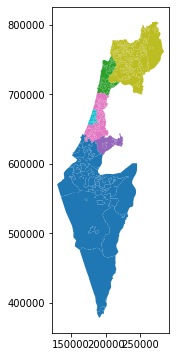

In [95]:
towns.plot(column='Machoz');

(rail-layer)=
### Railway lines

Next, we read the railway line layer, from the Shapefile named `RAIL_STRATEGIC.shp`. We subset the layer by attributes (see {ref}`subsetting-by-attributes`) to retain just the active railway segments. Then, we subset just the `"SEGMENT"` (segment name) and `"geometry"` columns: 

In [96]:
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
rail = rail[rail['ISACTIVE'] == 'פעיל']
rail = rail[['SEGMENT', 'geometry']]
rail

SEGMENT                            geometry
0             כפר יהושע - נשר_1  LINESTRING (205530.083 741562.9...
1            באר יעקב-ראשונים_2  LINESTRING (181507.598 650706.1...
3         לב המפרץ מזרח - נשר_4  LINESTRING (203482.789 744181.5...
4             קרית גת - להבים_5  LINESTRING (178574.101 609392.9...
5            רמלה - רמלה מזרח_6  LINESTRING (189266.580 647211.5...
..                          ...                                 ...
210           ויתקין - חדרה_215  LINESTRING (190758.230 704950.0...
211  בית יהושע - נתניה ספיר_216  LINESTRING (187526.597 687360.3...
214       השמונה - בית המכס_220  LINESTRING (200874.999 746209.3...
215     לב המפרץ - בית המכס_221  LINESTRING (203769.786 744358.6...
216         224_לוד מרכז - נתבג  LINESTRING (190553.481 654170.3...

[161 rows x 2 columns]

Here is a plot of the `rail` layer, colored by segment name:

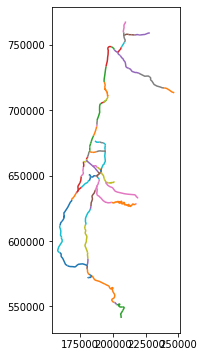

In [97]:
rail.plot(column='SEGMENT');

(stations-layer)=
### Railway stations

Finally, we read a layer of rainway *stations*, from a Shapefile named `RAIL_STAT_ONOFF_MONTH.shp`. The attributes of interest which we retain (in addition to the `"geometry"`) are:

* `"STAT_NAMEH"`—Station name
* `"ON_7_DAY"`—Passengers entering the station at 7:00-8:00 during September 2020
* `"OFF_7_DAY"`—Passengers exiting the station at 7:00-8:00 during September 2020
* `"ON_17_DAY"`—Passengers entering the station at 17:00-18:00 during September 2020
* `"OFF_17_DAY"`—Passengers exiting the station at 17:00-18:00 during September 2020

In [98]:
stations = gpd.read_file('data/RAIL_STAT_ONOFF_MONTH.shp')
stations = stations[['STAT_NAMEH', 'ON_7_DAY', 'OFF_7_DAY', 'ON_17_DAY', 'OFF_17_DAY', 'geometry']]
stations

STAT_NAMEH  ON_7_DAY  OFF_7_DAY  ON_17_DAY  OFF_17_DAY  \
0   ראשון לציון משה דיין     129.0       72.0       71.0       123.0   
1        קרית ספיר נתניה      34.0      119.0      120.0        40.0   
2              ת"א השלום     158.0     1642.0     2091.0       355.0   
3                  שדרות      80.0       26.0       24.0        79.0   
4                   רמלה     140.0       47.0       34.0        87.0   
..                   ...       ...        ...        ...         ...   
58    מגדל העמק כפר ברוך      21.0        5.0        8.0        24.0   
59    באר שבע אוניברסיטה     212.0      130.0       89.0       184.0   
60          חיפה בת גלים     106.0      311.0      108.0        68.0   
61                   לוד     321.0      238.0      198.0       297.0   
62                 נהריה       0.0       64.0        0.0       326.0   

                         geometry  
0   POINT (177206.094 655059.936)  
1   POINT (187592.123 687587.598)  
2   POINT (180621.940 664537.210)  
3   POINT (160722.849 602798.889)  
4   POINT (188508.910 648466.870)  
..                            ...  
58  POINT (219851.931 728164.825)  
59  POINT (181813.614 574550.411)  
60  POINT (198610.010 748443.790)  
61  POINT (188315.977 650289.373)  
62  POINT (209570.590 767769.220)  

[63 rows x 6 columns]

Here is a visualization of the `stations` layer. Using symbology, we demonstrate that the largest number of passengers exiting a station in 7:00-8:00 are in Tel-Aviv, where lots of people travel to work:

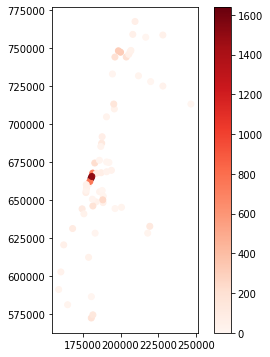

In [99]:
stations.plot(column='OFF_7_DAY', cmap='Reds', legend=True);

Here is the plot of the `towns`, `stations`, and `rail` layers, together (see {ref}`geopandas-plotting-more-than-one-layer`):

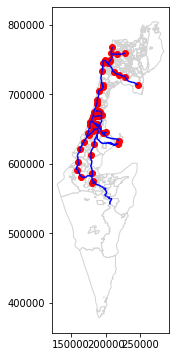

In [100]:
base = towns.plot(color='white', edgecolor='lightgrey')
stations.plot(ax=base, color='red')
rail.plot(ax=base, color='blue');

(geopandas-reprojection)=
## CRS and reprojection

(what-is-a-crs)=
### What is a CRS?

A Coordinate Reference System (CRS) defines the association between coordinates (which are ultimately just numbers) and specific locations on the surface of the earth. CRS can be divided into two groups:

* Geographic CRS, where units are degrees (e.g., WGS84)
* Projected CRS, where using are "real" distance units, typically meters (e.g., ITM, UTM)

There are several methods and formats to describe and specify a CRS. The shortest and simplest method is to use an EPSG code, which all standard CRS have. For example, {numref}`crs` specifies the CRS we encounter in this book, and their EPSG codes.

```{table} Coordinate Reference Systems (CRS) used in this book
:name: crs

| Name | Type | Units | EPSG code |
|---|---|---|---|
| WGS84 | Geographic | Degrees | `4326` |
| ITM | Projected | Meters | `2039` | 
| UTM Zone 36N | Projected | Meters | `32636` |
```

Geographic CRS refer to the entire surface of the Earth, while projected CRS commonly refer to smaller areas. A fundamental difference between geographical and projected CRS is in their units. Geographic CRS refer to location on a sphere, using degree units, while projected CRS refer to locations on an approximated planar surface. One important implication of the unit difference is that planar gemetric calculations (such as distance and area) make sense in projected CRS, but not in geographic CRS. 

```{note}
There are several formats, or standards, to specify a CRS, in Python and elsewhere. The most common ones are:

* An **EPSG code** (such as `4326`)
* A **PROJ string** (such as `"+proj=longlat +datum=WGS84 +no_defs"`)
* A **WKT string** (such as `"GEOGCS["WGS 84",DATUM["WGS_1984",...[etc.]"`)

In this book, we exclusively use EPSG codes to define projections, for their simplicity.
```

### Examining with `.crs`

As mentioned previously, the CRS definition of a `GeoDataFrame` (or a `GeoSeries`) is accessible through the `.crs` property (see {ref}`geodataframe-structure`). For example, here is the CRS information of the `rail` layer:

In [101]:
rail.crs

<Derived Projected CRS: EPSG:2039>
Name: Israel 1993 / Israeli TM Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Israel - onshore; Palestine Territory - onshore.
- bounds: (34.17, 29.45, 35.69, 33.28)
Coordinate Operation:
- name: Israeli TM
- method: Transverse Mercator
Datum: Israel 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The `rail` layer is in the ITM system. The EPSG code of this CRS is `2039`. Exploring the printout can also reveal that the CRS units are meters, and that the geographical area where the CRS is supposed to be used is Israel.

(geopandas-modifying-crs)=
### Modifying with `.set_crs`

To *modify* the CRS definition of a given layer, we can use the `.set_crs` method. In case the layer already has a CRS definition, we must use the `allow_override=True` option. Otherwise, we get an error. The `allow_override` argument is a safeguard against replacing the CRS definition of a layer when it already has one, which only makes sense if the existing CRS definition is wrong and we need to "fix" it (see below).

For example, the following expression replaces the CRS definition of `rail` (which is ITM, `2039`) with another CRS (WGS84, `4326`):

In [102]:
rail = rail.set_crs(4326, allow_override=True)

We can examine the `.crs` property, to see that the CRS definition has indeed changed:

In [103]:
rail.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

It is important to note that replacing the CRS definition has no effect on the coordinates. For example, the coordinates of `rail` are still in ITM units, rather than decimal degrees:

In [104]:
print(rail['geometry'].iloc[11])

LINESTRING (188700.0490851467 648249.5428679045, 188521.6542851487 648456.5536679029)


This means that the layer is now *incorrect* (!), since the coordinates do not match the CRS definition. Replacing the CRS definition should only be done when:

* The layer has no CRS definition, e.g., it was accidentally lost, and we need to restore it
* The CRS definition is *incorrect*, and we need to replace it

Let us now modify the CRS definition back to the original, to "fix" the layer we have just broken:

In [105]:
rail = rail.set_crs(2039, allow_override=True)

```{note}
To remove the CRS definition of a given layer altogether, you can assign `None` to the `.crs` property, as in `rail.crs=None`.
```

(reprojecting-with-to_crs)=
### Reprojecting with `.to_crs`

*Reprojecting* a vector layer involves not just replacing the CRS definition (see {ref}`geopandas-modifying-crs`), but also re-calculating all of the layer coordinates, so that they are in agreement with the new CRS.

To reproject a `GeoDataFrame`, or a `GeoSeries`, we use the `.to_crs` method. For example, here is how we can transform the `rail` layer to WGS84:

In [106]:
rail = rail.to_crs(4326)

Comparing the updated `.crs` property of `rail` with the original one (see above), we can see that the CRS definition indeed changed:

In [107]:
rail.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Importantly, the *coordinates* also changed, which can be demonstrated by printing the WKT representation of any given geometry from the layer (compare with the above printout):

In [108]:
print(rail['geometry'].iloc[11])

LINESTRING (34.87921676021756 31.92681756873793, 34.87732378978819 31.92867956007149)


Thus the information in the `rail` layer is still "correct", as the coordinates match the CRS. It is just in a different CRS.

Finally, we can see that the axis text labels when plotting the layer have changed, now reflecting decimal degree values of the WGS84 CRS:

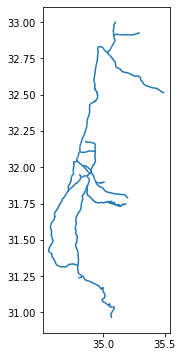

In [109]:
rail.plot();

Let us reproject `rail` back to the original CRS (i.e., ITM) before we proceed:

In [110]:
rail = rail.to_crs(epsg=2039)

```{note}
More information on specifying projections, and reprojecting layers, can be found in <https://geopandas.org/docs/user_guide/projections.html>.
```

(geopandas-numeric-calculations)=
## Numeric calculations

### Overview

In this section, we cover geometric commonly used calculations that result in numeric values, using `geopandas`. As we will see, the first three operations are very similar to their `shapely` counterparts ({numref}`numeric-calculations-shapely-geopandas`). The principle difference is that the calculation is applied on multiple geometries, rather than just one.

```{table} Numeric geometry calculations in <code>shapely</code> and <code>geopandas</code>
:name: numeric-calculations-shapely-geopandas

| Method | `shapely` | `geopandas` |
|---|---|---|
| `.length` | see {ref}`shapely-length` | see {ref}`geopandas-length` |
| `.area` | see {ref}`shapely-area` | see {ref}`geopandas-area` |
| `.distance` | see {ref}`shapely-distance` | see {ref}`geopandas-distance` |
```

The fourth operation, detecting *nearest neighbors* (see {ref}`nearest-neighbors`), is a little more complex and not really analogous to any `shapely`-based workflow, since it only makes sense to detect nearest neighbors when we have more than one geometry to choose from. 

(geopandas-length)=
### Length (`geopandas`)

The [`.length`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html) property returns a `Series` with line *lengths* per geometry in a `GeoDataFrame` (or a `GeoSeries`). For example, `rail.length` returns a `Series` of railway segment lengths:

In [111]:
rail.length

0      12379.715331
1       2274.111799
3       2793.337699
4       1960.170882
5       1195.701220
           ...     
210     5975.045997
211     1913.384027
214     1603.616014
215      166.180958
216     1284.983680
Length: 161, dtype: float64

Keep in mind that all numeric calculations, such as length, area (see {ref}`geopandas-area`), and distance (see {ref}`geopandas-distance`), are returned in the coordinate units, that is, in CRS units. In our case, the CRS is ITM, where the units are meters ($m$) ({numref}`crs`). The following expression transforms the values from $m$ to $km$:

In [112]:
rail.length / 1000

0      12.379715
1       2.274112
3       2.793338
4       1.960171
5       1.195701
         ...    
210     5.975046
211     1.913384
214     1.603616
215     0.166181
216     1.284984
Length: 161, dtype: float64

This `Series` can be assigned to into a new column, such as a column named `"length_km"`, as follows:

In [113]:
rail['length_km'] = rail.length / 1000
rail

SEGMENT                            geometry  length_km
0             כפר יהושע - נשר_1  LINESTRING (205530.083 741562.9...  12.379715
1            באר יעקב-ראשונים_2  LINESTRING (181507.598 650706.1...   2.274112
3         לב המפרץ מזרח - נשר_4  LINESTRING (203482.789 744181.5...   2.793338
4             קרית גת - להבים_5  LINESTRING (178574.101 609392.9...   1.960171
5            רמלה - רמלה מזרח_6  LINESTRING (189266.580 647211.5...   1.195701
..                          ...                                 ...        ...
210           ויתקין - חדרה_215  LINESTRING (190758.230 704950.0...   5.975046
211  בית יהושע - נתניה ספיר_216  LINESTRING (187526.597 687360.3...   1.913384
214       השמונה - בית המכס_220  LINESTRING (200874.999 746209.3...   1.603616
215     לב המפרץ - בית המכס_221  LINESTRING (203769.786 744358.6...   0.166181
216         224_לוד מרכז - נתבג  LINESTRING (190553.481 654170.3...   1.284984

[161 rows x 3 columns]

All geometric operations in `geopandas` assume *planar* geometry, returning the result in the CRS units. This means that layers in a geographic CRS (such as WGS84) need to be transformed to a projected CRS (see {ref}`what-is-a-crs`) before any geometric calculation. Otherwise, numeric measurements, such as length, area, and distance, are going to be returned in decimal degree units, which usually does not make sense, as the relation between degrees and geographic distance is not a fixed one.

```{admonition} Exercise 09-a
:class: important
* Reproject the `rail` layer to geographic coordinates (`4326`), than calculate railway lengths once again. You should see the (meaningless) results in decimal degrees.
```

(geopandas-area)=
### Area (`geopandas`)

The [`.area`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.area.html) property returns a `Series` with the *area* per geometry in a `GeoDataFrame` (or a `GeoSeries`). For example, `towns.area` returns the area sizes of each polygon in the `towns` layer, again in CRS units ($m^2$):

In [114]:
towns.area

0      2.001376e+05
1      1.597418e+09
2      6.177438e+06
3      9.850450e+05
4      6.104233e+04
           ...     
405    1.635240e+07
406    8.141962e+06
407    6.455340e+06
408    1.891242e+06
409    2.554627e+05
Length: 410, dtype: float64

If necessary, this series can be assigned to a new column. For example, the following expression divides the area values by a factor of $1000^2$, i.e., `1000**2` to convert from $m^2$ to $km^2$, then assigns the results to a new column named `"area_km2"`:

In [115]:
towns['area_km2'] = towns.area / 1000**2
towns

Muni_Heb   Machoz    Shape_Area  \
0    ללא שיפוט - אזור מעיליא     צפון  2.001376e+05   
1                        תמר     דרום  1.597418e+09   
2                        שהם     מרכז  6.177438e+06   
3                        שהם     מרכז  9.850450e+05   
4                   ראש פינה     צפון  6.104233e+04   
..                       ...      ...           ...   
405                   אופקים     דרום  1.635240e+07   
406                אבן יהודה     מרכז  8.141962e+06   
407                 אבו סנאן     צפון  6.455340e+06   
408                  אבו גוש  ירושלים  1.891242e+06   
409                 שדות נגב     דרום  2.554627e+05   

                               geometry     area_km2  
0    POLYGON Z ((225369.655 770523.6...     0.200138  
1    POLYGON Z ((206899.135 552967.8...  1597.417603  
2    POLYGON Z ((194329.250 655299.1...     6.177438  
3    POLYGON Z ((196236.573 657835.0...     0.985045  
4    POLYGON Z ((255150.135 764764.6...     0.061042  
..                                  ...          ...  
405  POLYGON Z ((164806.146 577898.8...    16.352399  
406  POLYGON Z ((189803.359 684152.9...     8.141962  
407  POLYGON Z ((212294.953 763168.8...     6.455340  
408  POLYGON Z ((209066.649 635655.2...     1.891242  
409  POLYGON Z ((162082.027 592043.1...     0.255463  

[410 rows x 5 columns]

```{admonition} Exercise 09-b
:class: important
* Find out the names of the largest and the smallest municipal area polygon, in terms of area size, based on the `towns` layer. (answer: `'ללא שיפוט - אזור נחל ארבל'` and `'רמת נגב'`)
```

```{admonition} Exercise 09-c
:class: important
* Check the association between the `"area"` column we calculated, and the `"Shape_Area"` column which is stored in the Shapefile, using a scatterplot (see {ref}`scatterplots`) ({numref}`exercise-09-c`).
```

```{glue:figure} exercise-09-c
---
name: exercise-09-c
---
Solution of exercise-09-c: Association between the (calculated) `"area"` column and the (original) `"Shape_Area"` column
```

(geopandas-distance)=
### Distance (`geopandas`)

The [`.distance`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html) method can be used to calculate *distances*. This method can be used to calculate pairwise distances between two `GeoSeries` (aligned by index or position), or between each geometry in one `GeoSeries` and another, individual, geometry. The following example demonstrates the latter. Here, we are calculating the distances between: 

* `stations`—all railway stations, and 
* `rail['geometry'].iloc[0]`—the *first* railway segment. 

The result is a `Series` of distances, in $m$:

In [116]:
stations.distance(rail['geometry'].iloc[0])

0      84284.975205
1      50424.920267
2      74235.170679
3     138847.580690
4      86603.473121
          ...      
58      8595.362486
59    160138.041969
60      9758.724335
61     84904.898970
62     26515.877484
Length: 63, dtype: float64

What if we need to calculate the *pairwise* distances, between each station and each railway segment? This can be done using `.apply` (see {ref}`apply-and-custom-functions`). The following [expression](https://stackoverflow.com/questions/64754025/calculate-all-distances-between-two-geodataframe-of-points-in-geopandas), in plain language, means that we take each row (`axis=1`) in `stations` as `x`, then calculate the `Series` of distances from all railway segments to the geometry of that row (`rail.distance(x["geometry"])`). 


The result is a `DataFrame` representing a *distance matrix*, where:

* Rows represent railway *stations*
* Columns represent railway *segments*
* Cell values are *distances*, in meters

In [117]:
d = stations.apply(lambda x: rail.distance(x['geometry']), axis=1)
d

0              1              3              4              5    \
0    84284.975205    6120.325293   91266.392666   43769.104489   13360.106887   
1    50424.920267   37379.975682   57120.870160   76795.773036   39353.653794   
2    74235.170679   13859.386195   81199.631964   53259.279461   18180.867522   
3   138847.580690   51367.336965  146064.901194   19030.199927   52794.173376   
4    86603.473121    5697.560021   94960.212976   38438.916853     289.422152   
..            ...            ...            ...            ...            ...   
58    8595.362486   86339.689331   20244.761995  123902.486603   85772.327241   
59  160138.041969   74611.504901  169029.718846   34992.788653   73042.322269   
60    9758.724335   99222.671750    6473.850217  138574.693149  100683.138956   
61   84904.898970    5579.557103   93200.557041   40156.246177    2075.672842   
62   26515.877484  120379.789258   24360.621700  159481.427917  121328.202345   

    ...            210            211            214            215  \
0   ...   46002.039665   31998.139305   94172.402848   93091.940077   
1   ...   11924.365438     236.552504   60107.821537   58958.887738   
2   ...   35958.589113   21932.455984   84145.901064   83037.130172   
3   ...  100790.724935   86796.547920  148925.381315  147885.212962   
4   ...   50857.456340   37074.116175   98521.682411   97044.665341   
..  ...            ...            ...            ...            ...   
58  ...   37220.552915   52057.048736   26186.457201   22822.683088   
59  ...  125012.376699  111083.909066  172714.053593  171172.498821   
60  ...   44196.792329   62080.870950    1709.845960    6471.883040   
61  ...   49040.957113   35245.583872   96738.721423   95275.546196   
62  ...   65575.558369   83375.846025   22375.584322   24118.556926   

              216  
0    13376.996382  
1    33548.162167  
2    14356.406044  
3    58403.590869  
4     4964.211497  
..            ...  
58   79583.761529  
59   78870.029306  
60   94617.022408  
61    3553.733949  
62  115179.615344  

[63 rows x 161 columns]

Note that the first column in the above result is identical to the `Series` we got in the previous expression.

The distance matrix can be refined to calculate more specific properties related to distance that we are interested in. For example, to get the *minimum* distance to *any* of the railway segments (rather than all distances), we can apply the `.min()` method on each row, as follows. The result is a `Series` of minimal distances per station:

In [118]:
nearest_seg_dist = d.min(axis=1)
nearest_seg_dist

0      13.440327
1       4.932094
2      16.180832
3      64.381044
4       2.941401
         ...    
58     56.102377
59      7.540327
60     44.130049
61     22.556829
62    115.502833
Length: 63, dtype: float64

We can assign it to a new column named `"nearest_seg_dist"` ("distance to nearest segment") in `stations`, as follows:

In [119]:
stations['nearest_seg_dist'] = nearest_seg_dist
stations

STAT_NAMEH  ON_7_DAY  OFF_7_DAY  ON_17_DAY  OFF_17_DAY  \
0   ראשון לציון משה דיין     129.0       72.0       71.0       123.0   
1        קרית ספיר נתניה      34.0      119.0      120.0        40.0   
2              ת"א השלום     158.0     1642.0     2091.0       355.0   
3                  שדרות      80.0       26.0       24.0        79.0   
4                   רמלה     140.0       47.0       34.0        87.0   
..                   ...       ...        ...        ...         ...   
58    מגדל העמק כפר ברוך      21.0        5.0        8.0        24.0   
59    באר שבע אוניברסיטה     212.0      130.0       89.0       184.0   
60          חיפה בת גלים     106.0      311.0      108.0        68.0   
61                   לוד     321.0      238.0      198.0       297.0   
62                 נהריה       0.0       64.0        0.0       326.0   

                         geometry  nearest_seg_dist  
0   POINT (177206.094 655059.936)         13.440327  
1   POINT (187592.123 687587.598)          4.932094  
2   POINT (180621.940 664537.210)         16.180832  
3   POINT (160722.849 602798.889)         64.381044  
4   POINT (188508.910 648466.870)          2.941401  
..                            ...               ...  
58  POINT (219851.931 728164.825)         56.102377  
59  POINT (181813.614 574550.411)          7.540327  
60  POINT (198610.010 748443.790)         44.130049  
61  POINT (188315.977 650289.373)         22.556829  
62  POINT (209570.590 767769.220)        115.502833  

[63 rows x 7 columns]

(nearest-neighbors)=
### Nearest neighbors

Here is another technique to extract information from the distance matrix, expanding the above expression of distance to nearest neighbor. This time, we calculate the name (`"SEGMENT"` column) of the nearest railway segment for each station. We are using the `.idxmin` method (see {numref}`pandas-aggregation-methods`), instead of `.min`, to get the *index* of the nearest segment (instead of the distance to it):

In [120]:
d.idxmin(axis=1)

0      22
1     100
2      57
3     131
4      87
     ... 
58    152
59    205
60    153
61     77
62     12
Length: 63, dtype: int64

The index can then be used to subset segment names (`rail["SEGMENT"]`). The result is a series of the nearest segment names:

In [121]:
nearest_seg_name = rail['SEGMENT'].loc[d.idxmin(axis=1)]
nearest_seg_name

22              משה דיין-קוממיות_23
100    נתניה מכללה - נתניה ספיר_101
57           סבידור מרכז - השלום_58
131              שדרות-יד מרדכי_134
87                    לוד - רמלה_88
                   ...             
152            עפולה - כפר ברוך_155
205    באר שבע צפון - באר שבע אוניב
153          חוף כרמל - בת גלים_156
77                    לוד - רמלה_78
12                   נהריה - עכו_13
Name: SEGMENT, Length: 63, dtype: object

Let us attach the result to another column in the `stations` table, named `nearest_seg_name` ("nearest segment name"). We need to reset the indices to make sure the column is attached by position:

In [122]:
nearest_seg_name = nearest_seg_name.reset_index(drop=True)
nearest_seg_name

0              משה דיין-קוממיות_23
1     נתניה מכללה - נתניה ספיר_101
2           סבידור מרכז - השלום_58
3               שדרות-יד מרדכי_134
4                    לוד - רמלה_88
                  ...             
58            עפולה - כפר ברוך_155
59    באר שבע צפון - באר שבע אוניב
60          חוף כרמל - בת גלים_156
61                   לוד - רמלה_78
62                  נהריה - עכו_13
Name: SEGMENT, Length: 63, dtype: object

In [123]:
stations['nearest_seg_name'] = nearest_seg_name
stations

STAT_NAMEH  ON_7_DAY  OFF_7_DAY  ON_17_DAY  OFF_17_DAY  \
0   ראשון לציון משה דיין     129.0       72.0       71.0       123.0   
1        קרית ספיר נתניה      34.0      119.0      120.0        40.0   
2              ת"א השלום     158.0     1642.0     2091.0       355.0   
3                  שדרות      80.0       26.0       24.0        79.0   
4                   רמלה     140.0       47.0       34.0        87.0   
..                   ...       ...        ...        ...         ...   
58    מגדל העמק כפר ברוך      21.0        5.0        8.0        24.0   
59    באר שבע אוניברסיטה     212.0      130.0       89.0       184.0   
60          חיפה בת גלים     106.0      311.0      108.0        68.0   
61                   לוד     321.0      238.0      198.0       297.0   
62                 נהריה       0.0       64.0        0.0       326.0   

                         geometry  nearest_seg_dist  \
0   POINT (177206.094 655059.936)         13.440327   
1   POINT (187592.123 687587.598)          4.932094   
2   POINT (180621.940 664537.210)         16.180832   
3   POINT (160722.849 602798.889)         64.381044   
4   POINT (188508.910 648466.870)          2.941401   
..                            ...               ...   
58  POINT (219851.931 728164.825)         56.102377   
59  POINT (181813.614 574550.411)          7.540327   
60  POINT (198610.010 748443.790)         44.130049   
61  POINT (188315.977 650289.373)         22.556829   
62  POINT (209570.590 767769.220)        115.502833   

                nearest_seg_name  
0            משה דיין-קוממיות_23  
1   נתניה מכללה - נתניה ספיר_101  
2         סבידור מרכז - השלום_58  
3             שדרות-יד מרדכי_134  
4                  לוד - רמלה_88  
..                           ...  
58          עפולה - כפר ברוך_155  
59  באר שבע צפון - באר שבע אוניב  
60        חוף כרמל - בת גלים_156  
61                 לוד - רמלה_78  
62                נהריה - עכו_13  

[63 rows x 8 columns]

The last example can be considered as a "manually" constructed nearest-neighbor spatial join, since we actually joined an attribute (`"SEGMENT"`) value from one layer (`rail`) to another layer (`stations`), based on proximity. Towards the end of this chapter we will introduce the the `gpd.sjoin_nearest` function which can be used for nearest-neighbour spatial join using much shorter code (see {ref}`nearest-neighbor-join`).

(geopandas-new-geometries)=
## New geometries

### Overview

In this section, we learn about functions that calculate new geometries. We are already familiar with the analogous operation for individual geometries (see {ref}`shapely-new-geometries-1` and {ref}`shapely-new-geometries-2`). Now, we learn about the same type of operations for layers, which include more than one geometry. In general, the operation is repeated for each geometry, or each pair of geometries, resulting in a new geometry column with the results. For example, when applying a "centroid" function on a vector layer or geometry column, we get a new geometry column, with the same number of geometries as the original, where each geometry is the centroid of the respective original geometry. 

Just like when discussing the `shapely` functions, we can distinguish between functions that accept a single layer (see {ref}`geopandas-centroids` and {ref}`geopandas-buffers`) and functions that accept a pair of layers (see {ref}`geopandas-set-operations`). The first two methods (`.centroid` and `.buffer`) are very similar in `shapely` and `geopandas`. Creating new geometries based on pairs of input geometries, however, is different ({numref}`new-geometry-shapely-geopandas`):

* In `shapely`, there are specific functions for each pairwise algorithm (`.intersection`, `.union`, `.difference`) (see {ref}`shapely-new-geometries-2`)
* In `geopandas`, there is one method (`.overlay`) where the algorithm is specified using the `how` argument (see {ref}`geopandas-set-operations`)

```{table} New geometry calculations in <code>shapely</code> and <code>geopandas</code>
:name: new-geometry-shapely-geopandas

| Method | `shapely` | `geopandas` |
|---|---|---|
| `.centroid` | {ref}`shapely-centroid` | {ref}`geopandas-centroids` |
| `.buffer()` | {ref}`shapely-buffer` | {ref}`geopandas-buffers` |
| `.intersection` / `.overlay(..., how="intersection")` | {ref}`shapely-intersection` | {ref}`geopandas-set-operations` |
| `.union` / `.overlay(..., how="union")` | {ref}`shapely-union` | {ref}`geopandas-set-operations` |
| `.difference` / `.overlay(..., how="difference")` | {ref}`shapely-difference` | {ref}`geopandas-set-operations` |
```

```{note}
`geopandas` also has the [`.intersection`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersection.html), [`.union`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.union.html), and [`.difference`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html) methods, but these operate on the geometric part of the vector layer only (the `GeoSeries`). Therefore, they do not preserve the attribute data, which is rarely what we want.
```

(geopandas-centroids)=
### Centroids (`geopandas`)

The [`.centroid`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.centroid.html) method, applied on a `GeoDataFrame` or `GeoSeries`, returns a new `GeoSeries` with the centroids. For example, here is how we can create a `GeoSeries` of town polygon centroids:

In [124]:
ctr = towns.centroid
ctr

0      POINT (225182.898 770809.745)
1      POINT (228716.918 561880.946)
2      POINT (195454.340 655942.058)
3      POINT (196351.843 658288.230)
4      POINT (254877.752 764800.811)
                   ...              
405    POINT (165198.012 579543.277)
406    POINT (189227.026 686069.086)
407    POINT (215379.077 763146.384)
408    POINT (210369.545 634906.185)
409    POINT (161682.995 591763.635)
Length: 410, dtype: geometry

And here is a plot of the result:

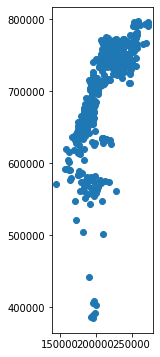

In [125]:
ctr.plot();

(geopandas-buffers)=
### Buffers (`geopandas`)

The [`.buffer`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) method buffers each geometry in a given `GeoDataFrame` or `GeoSeries` to the specified distance. It returns a `GeoSeries` with the resulting polygons. For example, here we create buffers of 10,000 $m$ (i.e., 10 $km$) around each railway station:

In [126]:
stations_buffer = stations.buffer(10000)
stations_buffer

0     POLYGON ((187206.094 655059.936...
1     POLYGON ((197592.123 687587.598...
2     POLYGON ((190621.940 664537.210...
3     POLYGON ((170722.849 602798.889...
4     POLYGON ((198508.910 648466.870...
                     ...                
58    POLYGON ((229851.931 728164.825...
59    POLYGON ((191813.614 574550.411...
60    POLYGON ((208610.010 748443.790...
61    POLYGON ((198315.977 650289.373...
62    POLYGON ((219570.590 767769.220...
Length: 63, dtype: geometry

Here is a plot of the result:

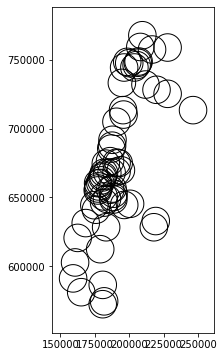

In [127]:
stations_buffer.plot(color='none');

```{admonition} Exercise 09-d
:class: important
* As shown above, centroids and buffers are returned as a `GeoSeries`. 
* Suppose that, instead, you need a `GeoDataFrame` with the original attributes of the source layer (e.g., the railway station properties) *and* the centroid, or buffer, geometries. How can we create such `GeoDataFrame`s?
```

(geopandas-set-operations)=
### Set-operations (`.overlay`)

We can apply set operations on geometry pairs, using the [`.overlay`](https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html) method, to obtain a new layer of the results. For example, `x.overlay(y,how="intersection"`) returns all the intersections between a feature in `x` and a feature in `y`. The `.overlay` method supports the same pairwise set operations that `shapely` does (see {ref}`shapely-new-geometries-2`), such as intersection or union. The principal difference is that we are executing the operation on a multple pairs of geometries, coming from two layers, rather than just two individual geometries. Accordingly, we get back a layer with the pairwise results. In other words, the operation is executed for each combination of one geometry taken from the first series and one geometry taken from the other series.

The `how` argument of `.overlay` specifies the type of the set operation. It can be one of:
    
* `"intersection"` (the default)
* `"union"`
* `"difference"`
* `"symmetric_difference"`
* `"identity"`

For example, the following expression calculates the pairwise intersections between railway segments (`rail`) and towns (`towns`), creating a new layer of pairwise intersections `rail_towns`:

In [128]:
rail_towns = rail[['SEGMENT', 'length_km', 'geometry']].overlay(towns[['Muni_Heb', 'geometry']])
rail_towns

SEGMENT  length_km            Muni_Heb  \
0                כפר יהושע - נשר_1  12.379715          עמק יזרעאל   
1          כפר יהושע - כפר ברוך_66   8.949254          עמק יזרעאל   
2             עפולה - כפר ברוך_155   8.964256          עמק יזרעאל   
3                כפר יהושע - נשר_1  12.379715              זבולון   
4                כפר יהושע - נשר_1  12.379715          קרית טבעון   
..                             ...        ...                 ...   
277  בנימינה - קיסריה-פרדס חנה_165   2.477533  בנימינה - גבעת עדה   
278          בית שאן - תל יוסף_180   8.672871             בית שאן   
279   בני ברק - אוניברסיטת תל אביב   1.547173              רמת גן   
280   בני ברק - אוניברסיטת תל אביב   1.547173             בני ברק   
281        בני ברק - קרית אריה_191   3.135967             בני ברק   

                               geometry  
0    LINESTRING Z (210658.396 732427...  
1    LINESTRING Z (212065.462 731805...  
2    LINESTRING Z (219817.610 728118...  
3    LINESTRING Z (206157.238 740691...  
4    LINESTRING Z (210111.094 732877...  
..                                  ...  
277  LINESTRING Z (195790.240 711799...  
278  LINESTRING Z (244593.016 714103...  
279  LINESTRING Z (183903.623 667802...  
280  LINESTRING Z (184162.640 667780...  
281  LINESTRING Z (185847.279 667798...  

[282 rows x 4 columns]

To understand what has happened, consider a specific segment in the `rail` layer:

In [129]:
x = rail[rail['SEGMENT'] == 'רחובות גבירול-יבנה מזרח_53']
x

SEGMENT                            geometry  length_km
52  רחובות גבירול-יבנה מזרח_53  LINESTRING (175871.680 640999.6...   6.611288

Here is a plot of this particular segment:

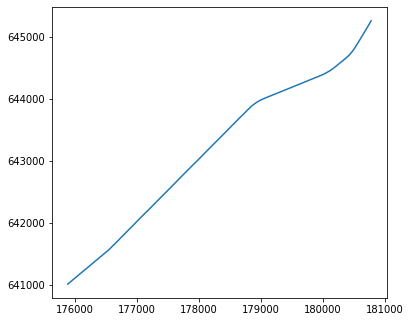

In [130]:
x.plot();

In the result of the overlay operation, this segment was split into three parts, since it crosses three different geometries from the `towns` layer. We can see, in the result, the names of the `towns` feature that the sub- railway segment crosses:

In [131]:
y = rail_towns[rail_towns['SEGMENT'] == 'רחובות גבירול-יבנה מזרח_53']
y

SEGMENT  length_km Muni_Heb  \
82   רחובות גבירול-יבנה מזרח_53   6.611288     יבנה   
85   רחובות גבירול-יבנה מזרח_53   6.611288   גן רוה   
134  רחובות גבירול-יבנה מזרח_53   6.611288   רחובות   

                               geometry  
82   LINESTRING Z (175871.680 640999...  
85   LINESTRING Z (176705.464 641722...  
134  LINESTRING Z (179037.308 643998...

as demonstrated in the following plot:

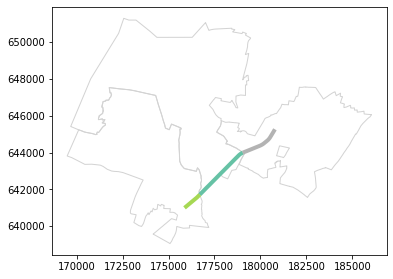

In [132]:
base = towns[towns['Muni_Heb'].isin(y['Muni_Heb'])].plot(color='none', edgecolor='lightgrey', zorder=1)
y.plot(ax=base, column='Muni_Heb', cmap='Set2', linewidth=4, zorder=2);

Note that the `length` attribute was "inherited" from the original `rail` layer, and it no longer represents the length of the sub-segments resulting from the overlay operation. If necessary, we can "update" the length attribute by recalculating geometry lengths:

In [133]:
rail_towns['length_km'] = rail_towns.length / 1000

Now the `"length_km"` attribute in `rail_towns` is correct:

In [134]:
rail_towns[rail_towns['SEGMENT'] == 'רחובות גבירול-יבנה מזרח_53']

SEGMENT  length_km Muni_Heb  \
82   רחובות גבירול-יבנה מזרח_53   1.104030     יבנה   
85   רחובות גבירול-יבנה מזרח_53   3.264937   גן רוה   
134  רחובות גבירול-יבנה מזרח_53   2.242321   רחובות   

                               geometry  
82   LINESTRING Z (175871.680 640999...  
85   LINESTRING Z (176705.464 641722...  
134  LINESTRING Z (179037.308 643998...

The sum of the sub-segment lenghts is (approximately) equal to the length of the complete original segment, as can be expected:

In [135]:
x = rail_towns[rail_towns['SEGMENT'] == 'רחובות גבירול-יבנה מזרח_53']['length_km'].sum()
y = rail[rail['SEGMENT'] == 'רחובות גבירול-יבנה מזרח_53']['length_km'].iloc[0]
x - y

8.881784197001252e-16

```{note}
For more information on set operations in `geopandas`, see <https://geopandas.org/docs/user_guide/set_operations.html>.
```

(geopandas-unary-union)=
### Unary union (`.unary_union`)

It is also worth mentioning the [`.unary_union`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html) property, which returns the union of all geometries in a `GeoSeries`. It can be thought of as sucessive pairwise union of all geometries in a layer, but more efficient and using a short expression rather than a loop. The output of `.unary_union` is a `shapely` geometry, as union of all geometries into one "loses" the attribute data, if any.

For example, `rail.unary_union` returns a `"MultiLineString"` geometry of all railway lines combined into one multi-part geometry:

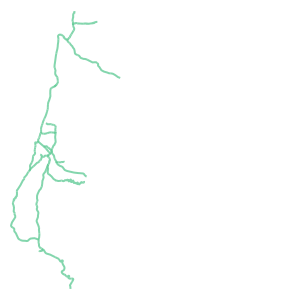

In [136]:
rail.unary_union

`.unary_union` can be useful when we need to treat all geometries as a single unit. For example, suppose we want to calculate the area that is within 1.5 $km$ of any railway lines. `.unary_union` comes in handy:

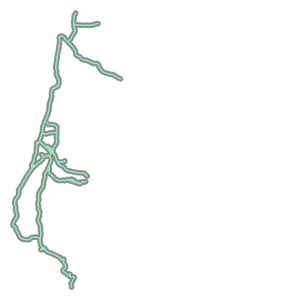

In [137]:
rail.unary_union.buffer(1500)  ## 1.5 km buffer around combined railway lines

In [138]:
rail.unary_union.buffer(1500).area / 1000**2  ## Area in km^2

1840.1464164468266

(geopandas-dissolve)=
## Aggregation (`.dissolve`)

### What is dissolving?

Aggregating a vector layer is similar to aggregating a table (see {ref}`pandas-aggregation`), in the sense that particular functions are applied on groups of rows, to summarize column values per group. The difference is that, when aggregating a vector layer, the geometries are aggregated as well, through *dissolving*, as in `.unary_union` (see {ref}`geopandas-unary-union`). 

For example, the `towns` layer has duplicate polygons per town, in cases when a particular town is discontinous, i.e., composed of more than one "part". We can find that out using the `.value_counts` method (see {ref}`pandas-value-counts`), which returns the number of occurences of each value in a `Series`:

In [139]:
towns['Muni_Heb'].value_counts()

מבואות החרמון                        12
מעלה יוסף                             6
הגליל העליון                          6
מרום הגליל                            5
נווה מדבר                             5
                                     ..
ללא שיפוט - נחל יתלה                  1
ללא שיפוט - אזור תע"ש                 1
ללא שיפוט - אזור תל השומר             1
ללא שיפוט - אזור שמורת שער העמקים     1
אבו גוש                               1
Name: Muni_Heb, Length: 290, dtype: int64

We can immediately see that the count `Series` contains values greater than `1` (up to `12`), which means that there are towns represented by more than one row. For example, the regional council named `"מבואות החרמון"` is composed of 12 separate parts:

In [140]:
towns[towns['Muni_Heb'] == 'מבואות החרמון']

Muni_Heb Machoz    Shape_Area                            geometry  \
88  מבואות החרמון   צפון  3.610206e+06  POLYGON Z ((256646.431 792500.5...   
89  מבואות החרמון   צפון  5.610637e+06  POLYGON Z ((252583.953 792643.3...   
90  מבואות החרמון   צפון  4.515282e+06  POLYGON Z ((262438.235 792883.0...   
91  מבואות החרמון   צפון  4.447152e+06  POLYGON Z ((257523.972 791631.4...   
92  מבואות החרמון   צפון  6.743527e+07  POLYGON Z ((253621.386 770548.1...   
..            ...    ...           ...                                 ...   
95  מבואות החרמון   צפון  1.336877e+07  POLYGON Z ((259270.552 762725.8...   
96  מבואות החרמון   צפון  1.238126e+07  POLYGON Z ((256798.730 762797.8...   
97  מבואות החרמון   צפון  1.699528e+06  POLYGON Z ((256108.896 758208.2...   
98  מבואות החרמון   צפון  1.077375e+07  POLYGON Z ((252450.242 756858.5...   
99  מבואות החרמון   צפון  2.424360e+06  POLYGON Z ((255326.620 757732.8...   

     area_km2  
88   3.610206  
89   5.610637  
90   4.515282  
91   4.447152  
92  67.435270  
..        ...  
95  13.368774  
96  12.381256  
97   1.699528  
98  10.773754  
99   2.424360  

[12 rows x 5 columns]

<AxesSubplot:>

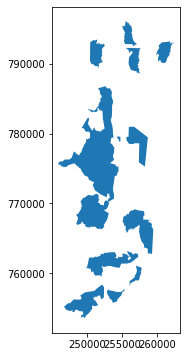

In [141]:
towns[towns['Muni_Heb'] == 'מבואות החרמון'].plot()

We can also see that all geometries are of type `"Polygon"`:

In [142]:
towns['geometry'].geom_type.value_counts()

Polygon    410
dtype: int64

We will see, in a moment that aggregation of a `"Polygon"` layer may create `"MultiPolygon"` geometries. For example, as a result of dissolving the `towns` layer by town name, the 12 rows with `"Polygon"` geometries of `"מבואות החרמון"` are going to turn into one row, with a `"MultiPolygon"` geometry (see below, {ref}`dissolving-by-town-name`). 

(dissolving-by-town-name)=
### Dissolving by town name

Usually we want to have each towns' information in a single row, to treat it as one unit. For instance, we usually are interested in the total `.area` of all parts of each town, at once, even if they are discontinuous in space. Therefore, we prefer to work with an aggregated the `towns` layer, grouping by town names (`"Muni_Heb"`). 

With `geopandas`, a vector layer can be aggregated using the [`.dissolve`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html) method, specifying: 

* `by`—The name of the column used for to grouping
* `aggfunc`—The function used to summarize the non-spatial columns:
    * `"first"` (the default)
    * `"last"`
    * `"min"`
    * `"max"`
    * `"sum"`
    * `"mean"`
    * `"median"`

For example, the following expression aggregates the `towns` layer by town name (`"Muni_Heb"`), taking the first value of all other attributes per town:

In [143]:
towns = towns.dissolve(by='Muni_Heb')
towns

geometry   Machoz    Shape_Area  \
Muni_Heb                                                                   
אבו גוש        POLYGON Z ((209066.649 635655.2...  ירושלים  1.891242e+06   
אבו סנאן       POLYGON Z ((212294.953 763168.8...     צפון  6.455340e+06   
אבן יהודה      POLYGON Z ((189803.359 684152.9...     מרכז  8.141962e+06   
אום אל פחם     MULTIPOLYGON Z (((212458.789 71...     חיפה  2.988196e+05   
אופקים         POLYGON Z ((164806.146 577898.8...     דרום  1.635240e+07   
...                                           ...      ...           ...   
שפרעם          POLYGON Z ((215213.126 744570.3...     צפון  1.962968e+07   
תל אביב - יפו  POLYGON Z ((183893.870 668086.9...  תל אביב  5.709679e+07   
תל מונד        POLYGON Z ((190787.125 681015.0...     מרכז  7.126864e+06   
תל שבע         POLYGON Z ((186092.189 571779.8...     דרום  9.421072e+06   
תמר            MULTIPOLYGON Z (((207660.539 55...     דרום  1.597418e+09   

                  area_km2  
Muni_Heb                    
אבו גוש           1.891242  
אבו סנאן          6.455340  
אבן יהודה         8.141962  
אום אל פחם        0.298820  
אופקים           16.352399  
...                    ...  
שפרעם            19.629682  
תל אביב - יפו    57.096785  
תל מונד           7.126864  
תל שבע            9.421072  
תמר            1597.417603  

[290 rows x 4 columns]

Just like in ordinary aggregation, the column which is used for grouping is automatically transferred to the *index* of the resulting `GeoDataFrame`. To place it back to an ordinary column, we can use the `.reset_index` method (see {ref}`resetting-the-index`):

In [144]:
towns = towns.reset_index()
towns

Muni_Heb                            geometry   Machoz    Shape_Area  \
0          אבו גוש  POLYGON Z ((209066.649 635655.2...  ירושלים  1.891242e+06   
1         אבו סנאן  POLYGON Z ((212294.953 763168.8...     צפון  6.455340e+06   
2        אבן יהודה  POLYGON Z ((189803.359 684152.9...     מרכז  8.141962e+06   
3       אום אל פחם  MULTIPOLYGON Z (((212458.789 71...     חיפה  2.988196e+05   
4           אופקים  POLYGON Z ((164806.146 577898.8...     דרום  1.635240e+07   
..             ...                                 ...      ...           ...   
285          שפרעם  POLYGON Z ((215213.126 744570.3...     צפון  1.962968e+07   
286  תל אביב - יפו  POLYGON Z ((183893.870 668086.9...  תל אביב  5.709679e+07   
287        תל מונד  POLYGON Z ((190787.125 681015.0...     מרכז  7.126864e+06   
288         תל שבע  POLYGON Z ((186092.189 571779.8...     דרום  9.421072e+06   
289            תמר  MULTIPOLYGON Z (((207660.539 55...     דרום  1.597418e+09   

        area_km2  
0       1.891242  
1       6.455340  
2       8.141962  
3       0.298820  
4      16.352399  
..           ...  
285    19.629682  
286    57.096785  
287     7.126864  
288     9.421072  
289  1597.417603  

[290 rows x 5 columns]

Note that we now have the same number of rows as the number of unique town names. Also note that some of the geometries are now of type `"MultiPolygon"` (why?):

In [145]:
towns['geometry'].geom_type.value_counts()

Polygon         228
MultiPolygon     62
dtype: int64

For example, here is the single entry for `"מבואות החרמון"`, which is now a `"MultiPolygon"` (composed of 12 parts):

In [146]:
towns[towns['Muni_Heb'] == 'מבואות החרמון']

Muni_Heb                            geometry Machoz    Shape_Area  \
182  מבואות החרמון  MULTIPOLYGON Z (((252449.171 75...   צפון  3.610206e+06   

     area_km2  
182  3.610206

Finally, the `"Shape_Area"` and `"area_km2"` columns are no longer correct (why?). We can drop one of them, and re-calculate the other:

In [147]:
towns = towns.drop('Shape_Area', axis=1)
towns['area_km2'] = towns.area / 1000**2
towns

Muni_Heb                            geometry   Machoz     area_km2
0          אבו גוש  POLYGON Z ((209066.649 635655.2...  ירושלים     1.891242
1         אבו סנאן  POLYGON Z ((212294.953 763168.8...     צפון     6.455340
2        אבן יהודה  POLYGON Z ((189803.359 684152.9...     מרכז     8.141962
3       אום אל פחם  MULTIPOLYGON Z (((212458.789 71...     חיפה    26.028286
4           אופקים  POLYGON Z ((164806.146 577898.8...     דרום    16.352399
..             ...                                 ...      ...          ...
285          שפרעם  POLYGON Z ((215213.126 744570.3...     צפון    19.629682
286  תל אביב - יפו  POLYGON Z ((183893.870 668086.9...  תל אביב    57.096785
287        תל מונד  POLYGON Z ((190787.125 681015.0...     מרכז     7.126864
288         תל שבע  POLYGON Z ((186092.189 571779.8...     דרום     9.421072
289            תמר  MULTIPOLYGON Z (((207660.539 55...     דרום  1623.029870

[290 rows x 4 columns]

Here is the revised entry for `"מבואות החרמון"`:

In [148]:
towns[towns['Muni_Heb'] == 'מבואות החרמון']

Muni_Heb                            geometry Machoz    area_km2
182  מבואות החרמון  MULTIPOLYGON Z (((252449.171 75...   צפון  134.816362

(dissolving-by-district)=
### Dissolving by district

As another example of dissolving, let us now use `"Machoz"` (district) as the grouping column. This refers to a higher-level administrative division, and there are just six districts in Israel. The dissoved layer is thus composed of six features:

In [149]:
districts = towns.dissolve(by='Machoz').reset_index()
districts

Machoz                            geometry    Muni_Heb   area_km2
0     דרום  POLYGON Z ((214342.276 467536.8...      אופקים  16.352399
1     חיפה  MULTIPOLYGON Z (((205862.732 70...  אום אל פחם  26.028286
2  ירושלים  POLYGON Z ((192405.812 638419.6...     אבו גוש   1.891242
3     מרכז  MULTIPOLYGON Z (((171159.359 63...   אבן יהודה   8.141962
4     צפון  MULTIPOLYGON Z (((204805.266 71...    אבו סנאן   6.455340
5  תל אביב  POLYGON Z ((177312.943 655809.6...   אור יהודה   6.730024

Here is a visualization of the resulting layer, colored by `"Machoz"` name so that we can see the placement of the regions in geographical space:

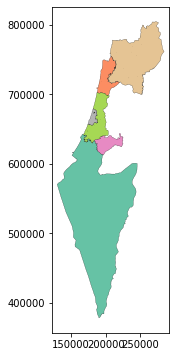

In [150]:
districts.plot(column='Machoz', cmap='Set2', edgecolor='black', linewidth=0.2);

Again, the `"Muni_Heb"` and `"area_km2"` attributes reflect the first value for each district and are no longer correct. We can either edit them manually (see {ref}`dissolving-by-town-name`), or use `aggfunc` other than `'first'` (see below, {ref}`using-aggfunc`).

(using-aggfunc)=
### Using `aggfunc`

As an example of using other `aggfunc` options, let us re-calculate the `"Machoz"` polygons, this time using `aggfunc="sum"`. Note that the function is automatically applied on the relevant (i.e., numeric) columns, in this case the `"Shape_Area"` and `"area"` columns.

In [151]:
districts = towns.dissolve(by='Machoz', aggfunc='sum').reset_index()
districts

Machoz                            geometry      area_km2
0     דרום  POLYGON Z ((214342.276 467536.8...  14476.526645
1     חיפה  MULTIPOLYGON Z (((205862.732 70...    895.010307
2  ירושלים  POLYGON Z ((192405.812 638419.6...    653.586307
3     מרכז  MULTIPOLYGON Z (((171159.359 63...   1312.566854
4     צפון  MULTIPOLYGON Z (((204805.266 71...   4649.160352
5  תל אביב  POLYGON Z ((177312.943 655809.6...    179.168299

This time, in the dissolved result, the `"area"` column contains the *summed* area of all geometries in each group, which is the correct value. Compare with the above result, where the column contained the value of just the first geometry, which is incorrect.

(geopandas-geometric-relations)=
## Geometric relations

The `geopandas` package contains a series of functions to evaluate spatial relations between geometries. For instance, in the next example, we are interested to examine which railway stations intersect with the area of Beer-Sheva, and then to subset those stations. To do that, in technical terms, we need to evaluate whether each geometry in the `stations` layer intersects with a particular geometry (Beer-Sheva) in the `towns` layer.

The `geopandas` package defines functions of the same name, analogous to the `shapely` boolean functions (see {ref}`shapely-boolean-methods`). Of those, `.intersects` is the most useful one. While the `shapely` version of `.intersects` returns a single boolean value, indicating whether the two geometries intersect (see {ref}`shapely-boolean-functions`), the `geopandas` version returns a boolean `Series` with pairwise results. There are two modes of operation:

* Pairwise results between two `GeoSeries` aligned by index or by position
* Results between all geometries in a `GeoSeries` and a single `shapely` geometry

In this example, we are going to demonstrate the *second* (simpler) workflow of `.intersects`, where we have a `GeoSeries` or a `GeoDataFrame` on the one hand, and an individual `shapely` geometry on the other hand. 

First of all, let us subset the `towns` layer to retain just the Beer-Sheva `shapely` polygon, as follows:

In [152]:
pol = towns[towns['Muni_Heb'] == 'באר שבע']
pol

Muni_Heb                            geometry Machoz    area_km2
22  באר שבע  POLYGON Z ((175342.311 568405.3...   דרום  117.393493

Here a visualization of the individual *geometry* from `pol`:

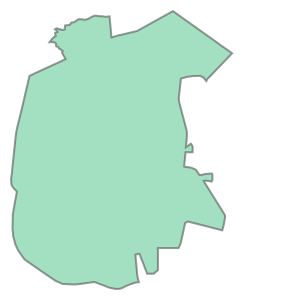

In [153]:
pol['geometry'].iloc[0]

Now, we are ready to evaluate the intersection between `stations`, on the one hand, and the `pol` geometry, on the other hand, using the `.intersects` method:

In [154]:
sel = stations.intersects(pol['geometry'].iloc[0])
sel

0     False
1     False
2     False
3     False
4     False
      ...  
58    False
59     True
60    False
61    False
62    False
Length: 63, dtype: bool

The result `sel` is a boolean `Series`, indicating for each `stations` feature whether it intersects with the Beer-Sheva polygon.

```{admonition} Exercise 09-e
:class: important
* How can we check how many of the `stations` features intersect with the polygon, i.e., to count the number of `True` values in the `sel` series?
```

Using the boolean `Series` from the previous code section, we can subset (see {ref}`dataframe-filtering`) the railway stations that are within Beer-Sheva:

In [155]:
stations[sel]

STAT_NAMEH  ON_7_DAY  OFF_7_DAY  ON_17_DAY  OFF_17_DAY  \
41        באר שבע מרכז       0.0      174.0        0.0       181.0   
59  באר שבע אוניברסיטה     212.0      130.0       89.0       184.0   

                         geometry  nearest_seg_dist  \
41  POINT (180768.910 572476.735)         34.113422   
59  POINT (181813.614 574550.411)          7.540327   

                nearest_seg_name  
41  באר שבע אוניברסיטה - באר שבע  
59  באר שבע צפון - באר שבע אוניב

Here is the plot of the resulting `stations` subset, on top of the town polygon used for filtering them:

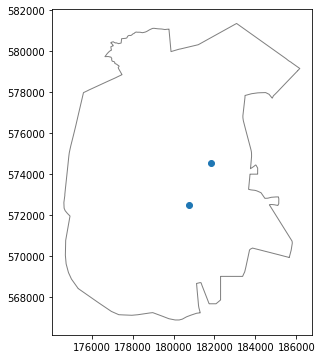

In [156]:
base = pol.plot(color='none', edgecolor='grey')
stations[sel].plot(ax=base);

```{note}
The `.intersects` method has other, more complicated, modes of operation, such as examining pairwise relations between geometries from two `GeoSeries` (composed of more than one geometry). See the documentation for details: <https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.intersects.html>. There are also analogous functions to evaluate standard spatial relations other than *intersection*, such as `.crosses`, `.contains`, `.touches`, `.disjoint`, etc.
```

(geopandas-spatial-join)=
## Spatial join

(ordinary-spatial-join)=
### Ordinary spatial join

*Spatial join* merges two spatial layers, in the same sense that an ordinary (i.e., non-spatial) join merges two tables (see {ref}`pandas-joining-tables`). The difference is that the features (i.e., rows) to join are not determined based on matching values in a common column. Instead, they are determined based on spatial relations. Typically, spatial join is based on the *intersection* (see {ref}`geopandas-geometric-relations`), which means that we are joining attributes of feature(s) from the second layer, that intersect with the given feature in the first layer. 

In `geopandas`, spatial join is done using the [`gpd.sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) ("spatial join") function. The `gpd.sjoin` function takes the following arguments:

* The first ("left") layer
* The second ("right") layer
* `how`—The type of join, one of: 
    * `'inner'` (the default)
    * `'left'` 
    * `'right'`
* `predicate`—The spatial relation to evaluate when looking for a match, one of: 
    * `'intersects'` (the default) 
    * `'contains'` 
    * `'crosses'` 
    * `'overlaps'` 
    * `'touches'` 
    * `'within'`

You may notice similarities with the `pd.merge` function for ordinary (non-spatial) join (see {ref}`pandas-joining-tables`). Namely, three of the four parameters are the same: the two tables/layers, and the `how` argument for join type. The difference is just the method for evaluating the matching rows/features:

* In an *ordinary* join, matching rows are determined based on identical values in a common column, specified using the `on` argument in `pd.merge`
* In a *spatial* join, matching features are determined based on spatial relations, such as whether the two features intersect or not, whereas the type of relation is specified using the `predicate` argument in `gpd.sjoin`

For example, the following spatial join operation reveals, for each railway station, which town it intersects with (i.e., located within). We also limit the input layers to just one attribute each, to see more clearly what is going on:

In [157]:
gpd.sjoin(
    stations[['STAT_NAMEH', 'geometry']], 
    towns[['Muni_Heb', 'geometry']], 
    how='left'
)

STAT_NAMEH                       geometry  index_right  \
0   ראשון לציון משה דיין  POINT (177206.094 655059.936)          263   
1        קרית ספיר נתניה  POINT (187592.123 687587.598)          219   
2              ת"א השלום  POINT (180621.940 664537.210)          286   
3                  שדרות  POINT (160722.849 602798.889)          283   
4                   רמלה  POINT (188508.910 648466.870)          269   
..                   ...                            ...          ...   
58    מגדל העמק כפר ברוך  POINT (219851.931 728164.825)          233   
59    באר שבע אוניברסיטה  POINT (181813.614 574550.411)           22   
60          חיפה בת גלים  POINT (198610.010 748443.790)           81   
61                   לוד  POINT (188315.977 650289.373)          123   
62                 נהריה  POINT (209570.590 767769.220)          210   

         Muni_Heb  
0     ראשון לציון  
1           נתניה  
2   תל אביב - יפו  
3        שער הנגב  
4            רמלה  
..            ...  
58     עמק יזרעאל  
59        באר שבע  
60           חיפה  
61            לוד  
62          נהריה  

[63 rows x 4 columns]

The spatial join result contains the attributes and geometry of the *left* layer, plus joined attributes and indices (`"index_right"`) of the *right* layer. In this case, we have:

* the `"STAT_NAMEH"`, `"geometry"` columns from the "left" `stations` layer, and 
* the `"index_right"` and `"Muni_Eng"` columns joined from the "right" `towns` layer.

For example, the first feature in the spatial join result reveals that the `"ראשון לציון משה דיין"` station is located in the town `"ראשון לציון"`.

As another, more complicated, example, the following spatial join might be a first attempt to can check which railway lines goes through each railway station: 

In [158]:
gpd.sjoin(
    stations[['STAT_NAMEH', 'geometry']], 
    rail, 
    how='left'
)

STAT_NAMEH                       geometry  index_right SEGMENT  \
0   ראשון לציון משה דיין  POINT (177206.094 655059.936)          NaN     NaN   
1        קרית ספיר נתניה  POINT (187592.123 687587.598)          NaN     NaN   
2              ת"א השלום  POINT (180621.940 664537.210)          NaN     NaN   
3                  שדרות  POINT (160722.849 602798.889)          NaN     NaN   
4                   רמלה  POINT (188508.910 648466.870)          NaN     NaN   
..                   ...                            ...          ...     ...   
58    מגדל העמק כפר ברוך  POINT (219851.931 728164.825)          NaN     NaN   
59    באר שבע אוניברסיטה  POINT (181813.614 574550.411)          NaN     NaN   
60          חיפה בת גלים  POINT (198610.010 748443.790)          NaN     NaN   
61                   לוד  POINT (188315.977 650289.373)          NaN     NaN   
62                 נהריה  POINT (209570.590 767769.220)          NaN     NaN   

    length_km  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
..        ...  
58        NaN  
59        NaN  
60        NaN  
61        NaN  
62        NaN  

[63 rows x 5 columns]

In this case, we see that none, or at least the first and last few, stations, had a match. This means that none of the lines *precisely* intersect with the station points.

One way to overcome this is to use nearest-neighbor join (see {ref}`nearest-neighbor-join`). Another option is to use a buffered version of the stations, say with a 100 $m$ buffer. In this case, we join the attributes of the segments that are *within* a 100 $m$ distance from each station:

In [159]:
stations1 = stations.copy()
stations1['geometry'] = stations1.buffer(100)
stations1[['STAT_NAMEH', 'geometry']]

STAT_NAMEH                            geometry
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...
1        קרית ספיר נתניה  POLYGON ((187692.123 687587.598...
2              ת"א השלום  POLYGON ((180721.940 664537.210...
3                  שדרות  POLYGON ((160822.849 602798.889...
4                   רמלה  POLYGON ((188608.910 648466.870...
..                   ...                                 ...
58    מגדל העמק כפר ברוך  POLYGON ((219951.931 728164.825...
59    באר שבע אוניברסיטה  POLYGON ((181913.614 574550.411...
60          חיפה בת גלים  POLYGON ((198710.010 748443.790...
61                   לוד  POLYGON ((188415.977 650289.373...
62                 נהריה  POLYGON ((209670.590 767769.220...

[63 rows x 2 columns]

Then, we join the *buffered* `stations1` with the `rail` layer:

In [160]:
gpd.sjoin(
    stations1[['STAT_NAMEH', 'geometry']], 
    rail, 
    how='left'
)

STAT_NAMEH                            geometry  index_right  \
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...         81.0   
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...         22.0   
1        קרית ספיר נתניה  POLYGON ((187692.123 687587.598...        100.0   
2              ת"א השלום  POLYGON ((180721.940 664537.210...         79.0   
2              ת"א השלום  POLYGON ((180721.940 664537.210...         57.0   
..                   ...                                 ...          ...   
60          חיפה בת גלים  POLYGON ((198710.010 748443.790...        153.0   
60          חיפה בת גלים  POLYGON ((198710.010 748443.790...        193.0   
61                   לוד  POLYGON ((188415.977 650289.373...         77.0   
61                   לוד  POLYGON ((188415.977 650289.373...        198.0   
62                 נהריה  POLYGON ((209670.590 767769.220...          NaN   

                         SEGMENT  length_km  
0              משה דיין-חולות_82   1.851570  
0            משה דיין-קוממיות_23   1.477394  
1   נתניה מכללה - נתניה ספיר_101   1.417325  
2            יצחק שדה - השלום_80   1.009135  
2         סבידור מרכז - השלום_58   1.286116  
..                           ...        ...  
60        חוף כרמל - בת גלים_156   6.121700  
60          השמונה - בת גלים_197   1.644544  
61                 לוד - רמלה_78   1.339807  
61             לוד-רמלה מערב_203   1.412130  
62                           NaN        NaN  

[113 rows x 5 columns]

In this case, there are even stations with more than one matching line (e.g., `"ראשון לציון משה דיין"`), because there can be more than one railway segment passing through a radius of 100 $m$ of a railway station. However, other stations still had zero matches (e.g., `"נהריה"`). This leads us to the second option of dealing with the situation, the nearest neighbor join (see below, {ref}`nearest-neighbor-join`).

```{admonition} Exercise 09-f
:class: important
* Note that the last station (`"נהריה"`) has "No Data" in the segment name column (`"SEGMENT"`). Can you explain why?
```

(nearest-neighbor-join)=
### Nearest neighbor join

In addition to spatial join based on "ordinary" relations such as intersection (see {ref}`ordinary-spatial-join`), the `geopandas` package also has a [`gpd.sjoin_nearest`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html) function for spatial join based on *nearest neighbors*. It works similarly to `gpd.sjoin`, but matches are determined based on shortest pairwise distance. 

The following expression joins the nearest railway line attributes (including segment name, `"SEGMENT"`) and specifies the distances in the `"dist"` column as requested using the `distance_col="dist"` argument:

In [161]:
stations = gpd.sjoin_nearest(
    stations[['STAT_NAMEH', 'nearest_seg_dist', 'nearest_seg_name', 'geometry']], 
    rail[['SEGMENT', 'geometry']], 
    distance_col='dist'
)
stations

STAT_NAMEH  nearest_seg_dist              nearest_seg_name  \
0   ראשון לציון משה דיין         13.440327           משה דיין-קוממיות_23   
12         בת ים קוממיות          2.711357           משה דיין-קוממיות_23   
1        קרית ספיר נתניה          4.932094  נתניה מכללה - נתניה ספיר_101   
2              ת"א השלום         16.180832        סבידור מרכז - השלום_58   
3                  שדרות         64.381044            שדרות-יד מרדכי_134   
..                   ...               ...                           ...   
58    מגדל העמק כפר ברוך         56.102377          עפולה - כפר ברוך_155   
59    באר שבע אוניברסיטה          7.540327  באר שבע צפון - באר שבע אוניב   
60          חיפה בת גלים         44.130049        חוף כרמל - בת גלים_156   
61                   לוד         22.556829                 לוד - רמלה_78   
62                 נהריה        115.502833                נהריה - עכו_13   

                         geometry  index_right                       SEGMENT  \
0   POINT (177206.094 655059.936)           22           משה דיין-קוממיות_23   
12  POINT (177404.549 656501.262)           22           משה דיין-קוממיות_23   
1   POINT (187592.123 687587.598)          100  נתניה מכללה - נתניה ספיר_101   
2   POINT (180621.940 664537.210)           57        סבידור מרכז - השלום_58   
3   POINT (160722.849 602798.889)          131            שדרות-יד מרדכי_134   
..                            ...          ...                           ...   
58  POINT (219851.931 728164.825)          152          עפולה - כפר ברוך_155   
59  POINT (181813.614 574550.411)          205  באר שבע צפון - באר שבע אוניב   
60  POINT (198610.010 748443.790)          153        חוף כרמל - בת גלים_156   
61  POINT (188315.977 650289.373)           77                 לוד - רמלה_78   
62  POINT (209570.590 767769.220)           12                נהריה - עכו_13   

          dist  
0    13.440327  
12    2.711357  
1     4.932094  
2    16.180832  
3    64.381044  
..         ...  
58   56.102377  
59    7.540327  
60   44.130049  
61   22.556829  
62  115.502833  

[63 rows x 7 columns]

This time, we get exactly one matching `rail` segment per `stations` point. In addition to the segment name (`"SEGMENT"`), the distance to the matched nearest segment is documented in the `"dist"` column. As you can see, the values in these two columns are identical to the `"nearest_seg_name"` and `"nearest_seg_dist"` columns, respectively, which we calculated earlier using a "manual" approach (see {ref}`nearest-neighbors`):

In [162]:
(stations['nearest_seg_name'] == stations['SEGMENT']).all()

True

In [163]:
(stations['nearest_seg_dist'] == stations['dist']).all()

True

```{note}
For more information, see the `gpd.sjoin_nearest` function documentation: <https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html>.
```

(exercise-geopandas2)=
## More exercises

```{admonition} Exercise 09-g
:class: important

* Read the towns (`muni_il.shp`) layers (see {ref}`geopandas2-sample-data`)
* Aggregate it according to the `"Machoz"` column to dissolve the towns into district polygons (see {ref}`dissolving-by-district`)
* Calculate the number of neighbors, i.e., districts it intersects with excluding self, that each district has. 
* Plot the result ({numref}`exercise-09-g`).
* Advanced: display labels with the number of neighbors per district ({numref}`exercise-09-g`), by adapting this StackOverflow [answer](https://stackoverflow.com/questions/38899190/geopandas-label-polygons#answer-42214156).
* Hint: 
    * Aggregate the towns layer according to the `"Machoz"` column to dissolve the towns into district polygons (see {ref}`geopandas-dissolve`).
    * Join the layer with itself, based on "intersection", to join each town with all of its neighbors, then use aggregation to calculate the sum of joined towns per town. You can create a `"count"` variable for each town, equal to `1`, then sum it when calculating the number of neighbors.
    * Subtract `1` to get the number of intersections excluding intersection with self, i.e., the number of neighbors.
```

```{glue:figure} exercise-09-g
---
name: exercise-09-g
---
Solution of exercise-09-g: Neighbor count per town
```

```{admonition} Exercise 09-h
:class: important
* Calculate the total population size in a 1 $km$ buffer around each railway station in `RAIL_STAT_ONOFF_MONTH.shp`, according to the population data in `statisticalareas_demography2019.gdb` (`Pop_Total`=total population).
* Sort the table, to see which stations are situated in the most dense and sparse areas ({numref}`exercise-09-h`).
* Go through the following steps:
    * Import both layers into `GeoDataFrame` objects.
    * Calculate the *area* of each statistical area polygon.
    * Fill the missing population estimates (in the `Pop_Total` column) with zeros.
    * Create a buffer of 1 $km$ around the station points.
    * Calculate a layer of pairwise intersections between the buffers and the statistical areas.
    * Calculate the area of each *intersection*.
    * Calculate the population count of each *intersection*. To do that, multiply the statistical area population count column (`Pop_Total`) by the ratio between the intersection area, and the original total area of that statistical area (which you calculated in the second step earlier). 
    * Aggregate the layer by rail station name, to calculate the total population count per 1 $km$ buffer around a station.
    * Sort the layer by population counts, to see which stations are situated in the most dense and sparse areas.
```

```{glue:figure} exercise-09-h
---
name: exercise-09-h
---
Solution of exercise-09-h: Railway stations with largest and smallest population counts in a 1 km buffer
```

```{admonition} Exercise 09-i
:class: important
* Read the following vector layers (see {ref}`geopandas2-sample-data`):
    * Towns (`muni_il.shp`)
    * Railway lines (`RAIL_STRATEGIC.shp`) 
* Aggregate the towns layer according to the `"Muni_Heb"` column to dissolve the separate polygons per town (see {ref}`geopandas-dissolve`).
* Subset only the *active* railway lines, i.e., where the value in the `"ISACTIVE"` column is equal to `"פעיל"` (see {ref}`subsetting-by-attributes`).
* Subset the town polygons that a railway line goes through.
* Plot the resulting subset of towns and the active railway lines together ({numref}`exercise-09-i`).
```

```{glue:figure} exercise-09-i
---
name: exercise-09-i
---
Solution of exercise-09-i: Towns (grey polygons) intersecting with active railway lines (black lines)
```